In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    cross_val_score,
    learning_curve
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score
)

In [2]:
# ============================================================================
# LOAD DATA
# ============================================================================
df = pd.read_csv("C:/Projects/Project Bi/data/hellowork_clustered.csv")
print("Dataset Info:")
df.info()
print("\n" + "="*80 + "\n")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6732 entries, 0 to 6731
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   emploi             6732 non-null   object 
 1   entreprise         6732 non-null   object 
 2   date_publication   6732 non-null   object 
 3   temps_travail      6732 non-null   int64  
 4   salaire_annuel     6732 non-null   float64
 5   categorie_salaire  6732 non-null   int64  
 6   region             6732 non-null   object 
 7   departement        6732 non-null   int64  
 8   cluster            6732 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 473.5+ KB




In [3]:
df.head()

,emploi,entreprise,date_publication,temps_travail,salaire_annuel,categorie_salaire,region,departement,cluster
0,Poseur de Menuiserie H/F,Art & Fenêtres,2025-12-16 17:08:30.246736,1,29100.0,1,Cusset - Vichy,3,0
1,Animateur Commercial Multi-Sites H/F,123 Pare-Brise,2025-12-16 16:08:30.247158,1,39972.0,1,Tours,37,0
2,Chef de Projet - Génie des Procédés H/F,Sugar Consulting,2025-12-16 17:08:30.248221,1,52500.0,1,Solaize,69,0
3,Manager Commercial H/F,123 Pare-Brise,2025-12-16 17:08:30.248613,1,39144.0,1,Nord,59,0
4,Électricien Tertiaire - Industriel H/F,Squiban Group,2025-12-16 17:08:30.249039,1,934.0,0,Plougastel-Daoulas,29,3


In [4]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.freq_maps_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=self.columns)
        for col in self.columns:
            self.freq_maps_[col] = X[col].value_counts(normalize=True)
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns)
        X_encoded = pd.DataFrame()
        for col in self.columns:
            X_encoded[col] = X[col].map(self.freq_maps_[col]).fillna(0)
        return X_encoded.values

In [16]:
X = df.drop(columns=["cluster"])
y = df["cluster"]
binary_features = ["temps_travail"]
numeric_features = ["salaire_annuel"]
categorical_features = ["emploi", "entreprise", "region","departement"]

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6732 entries, 0 to 6731
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   emploi             6732 non-null   object 
 1   entreprise         6732 non-null   object 
 2   date_publication   6732 non-null   object 
 3   temps_travail      6732 non-null   int64  
 4   salaire_annuel     6732 non-null   float64
 5   categorie_salaire  6732 non-null   int64  
 6   region             6732 non-null   object 
 7   departement        6732 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 420.9+ KB


In [7]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 6732 entries, 0 to 6731
Series name: cluster
Non-Null Count  Dtype
--------------  -----
6732 non-null   int64
dtypes: int64(1)
memory usage: 52.7 KB


In [17]:
# ============================================================================
# TEST 1: CHECK FOR DATA LEAKAGE
# ============================================================================
print("="*80)
print("TEST 1: CHECKING FOR DATA LEAKAGE")
print("="*80)

# Check correlations with target (only for numeric columns)
numeric_cols = X.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    correlations = X[numeric_cols].corrwith(y)
    high_corr = correlations[abs(correlations) > 0.95]
    if len(high_corr) > 0:
        print("⚠️ WARNING: Features highly correlated with target (potential leakage):")
        print(high_corr.sort_values(ascending=False))
    else:
        print("✓ No features with >0.95 correlation to target")
else:
    print("✓ No numeric features to check for correlation")

# Check for duplicate rows
print(f"\nDuplicate rows in dataset: {X.duplicated().sum()}")

# Check if 'categorie_salaire' might be leaking information
if 'categorie_salaire' in X.columns:
    print("\n⚠️ NOTE: 'categorie_salaire' is in features - check if it's derived from target!")

print("\n" + "="*80 + "\n")

TEST 1: CHECKING FOR DATA LEAKAGE
✓ No features with >0.95 correlation to target

Duplicate rows in dataset: 0

⚠️ NOTE: 'categorie_salaire' is in features - check if it's derived from target!




In [18]:
# ============================================================================
# TEST 2: CREATE PROPER TRAIN/VAL/TEST SPLIT
# ============================================================================
print("="*80)
print("TEST 2: CREATING TRAIN/VALIDATION/TEST SPLIT")
print("="*80)

# First split: separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Second split: train and validation (70% train, 15% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.18, random_state=42, stratify=y_temp
)

print(f"Train size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation size: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Check for overlap
train_val_overlap = pd.merge(
    X_train.reset_index(drop=True),
    X_val.reset_index(drop=True),
    how='inner'
)
print(f"\n✓ Overlapping samples between train and validation: {len(train_val_overlap)}")

print("\n" + "="*80 + "\n")

TEST 2: CREATING TRAIN/VALIDATION/TEST SPLIT
Train size: 4692 (69.7%)
Validation size: 1030 (15.3%)
Test size: 1010 (15.0%)

✓ Overlapping samples between train and validation: 0




In [19]:
# ============================================================================
# PREPROCESSING PIPELINE
# ============================================================================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numeric_features),
        ("cat", FrequencyEncoder(categorical_features), categorical_features),
        ("bin", "passthrough", binary_features),
    ],
    remainder="drop"
)

pipeline_reduction = Pipeline([
    ("preprocessor", preprocessor),
])

# ============================================================================
# MODELS DEFINITION
# ============================================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf"),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}


In [34]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf"),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}


In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted"
}

results = []


In [33]:
for name, model in models.items():
    pipeline = Pipeline([
        ("reduction", pipeline_reduction),
        ("classifier", model)
    ])

    cv_results = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )

    print(f"\n{name}:")
    print(f"  Train F1-score: {cv_results['train_f1'].mean():.6f}")
    print(f"  CV F1-score: {cv_results['test_f1'].mean():.6f}")
    print(f"  F1-score Gap: {cv_results['train_f1'].mean() - cv_results['test_f1'].mean():.6f}")

    results.append({
        "Model": name,
        "Train F1-score": cv_results["train_f1"].mean(),
        "CV F1-score": cv_results["test_f1"].mean(),
        "F1-score Gap": cv_results["train_f1"].mean() - cv_results["test_f1"].mean()
    })

results_df = pd.DataFrame(results).sort_values(by="CV F1-score", ascending=False)

print("\n" + "="*80)
print("CROSS-VALIDATION SUMMARY:")
print("="*80)
print(results_df.to_string(index=False))
print("\n" + "="*80 + "\n")


Logistic Regression:
  Train F1-score: 1.000000
  CV F1-score: 1.000000
  F1-score Gap: 0.000000

Random Forest:
  Train F1-score: 1.000000
  CV F1-score: 1.000000
  F1-score Gap: 0.000000

SVM:
  Train F1-score: 0.977377
  CV F1-score: 0.977360
  F1-score Gap: 0.000016

KNN:
  Train F1-score: 1.000000
  CV F1-score: 1.000000
  F1-score Gap: 0.000000

Gradient Boosting:
  Train F1-score: 1.000000
  CV F1-score: 1.000000
  F1-score Gap: 0.000000

CROSS-VALIDATION SUMMARY:
              Model  Train F1-score  CV F1-score  F1-score Gap
Logistic Regression        1.000000      1.00000      0.000000
      Random Forest        1.000000      1.00000      0.000000
                KNN        1.000000      1.00000      0.000000
Logistic Regression        1.000000      1.00000      0.000000
  Gradient Boosting        1.000000      1.00000      0.000000
      Random Forest        1.000000      1.00000      0.000000
                KNN        1.000000      1.00000      0.000000
  Gradient Boosting

In [23]:
# ============================================================================
# TEST 5: FINAL TEST ON HOLDOUT TEST SET
# ============================================================================
print("="*80)
print("TEST 5: FINAL HOLDOUT TEST SET PERFORMANCE")
print("="*80)

best_model_name = "Logistic Regression"
best_model = models[best_model_name]

print(f"🏆 Best Model: {best_model_name}\n")

final_pipeline = Pipeline([
    ("reduction", pipeline_reduction),
    ("classifier", best_model)
])

final_pipeline.fit(X_train, y_train)

# Predictions
y_train_pred = final_pipeline.predict(X_train)
y_val_pred = final_pipeline.predict(X_val)
y_test_pred = final_pipeline.predict(X_test)

# Calculate F1 scores
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Train F1-score: {train_f1:.6f}")
print(f"Validation F1-score: {val_f1:.6f}")
print(f"Test F1-score: {test_f1:.6f}")
print(f"\nTest vs Train Gap: {train_f1 - test_f1:.6f}")
print(f"Test vs Validation Gap: {val_f1 - test_f1:.6f}")

if test_f1 > 0.99:
    print("\n⚠️ WARNING: Test F1-score is very high (>0.99)")
    print("   This could indicate:")
    print("   - Data leakage")
    print("   - Very easy classification problem")
    print("   - Target information in features")

print("\n" + "="*80)
print("CLASSIFICATION REPORT (TEST SET):")
print("="*80)
print(classification_report(y_test, y_test_pred))

print("\n" + "="*80 + "\n")


TEST 5: FINAL HOLDOUT TEST SET PERFORMANCE
🏆 Best Model: Logistic Regression

Train F1-score: 1.000000
Validation F1-score: 1.000000
Test F1-score: 1.000000

Test vs Train Gap: 0.000000
Test vs Validation Gap: 0.000000

⚠️ WARNING: Test F1-score is very high (>0.99)
   This could indicate:
   - Data leakage
   - Very easy classification problem
   - Target information in features

CLASSIFICATION REPORT (TEST SET):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       527
           1       1.00      1.00      1.00       275
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00       151

    accuracy                           1.00      1010
   macro avg       1.00      1.00      1.00      1010
weighted avg       1.00      1.00      1.00      1010





In [24]:

# ============================================================================
# TEST 6: FEATURE IMPORTANCE
# ============================================================================
print("="*80)
print("TEST 6: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

if hasattr(best_model, 'feature_importances_'):
    feature_names = numeric_features + categorical_features + binary_features
    importances = final_pipeline.named_steps['classifier'].feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10).to_string(index=False))

    # Check for dominant features
    if feature_importance_df.iloc[0]['Importance'] > 0.8:
        print(f"\n⚠️ WARNING: '{feature_importance_df.iloc[0]['Feature']}' has "
              f"{feature_importance_df.iloc[0]['Importance']:.2%} importance!")
        print("   This might indicate data leakage!")

    # Visualize
    plt.figure(figsize=(10, 6))
    top_10 = feature_importance_df.head(10)
    plt.barh(range(len(top_10)), top_10['Importance'])
    plt.yticks(range(len(top_10)), top_10['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

print("\n" + "="*80 + "\n")


TEST 6: FEATURE IMPORTANCE ANALYSIS




TEST 7: LEARNING CURVES


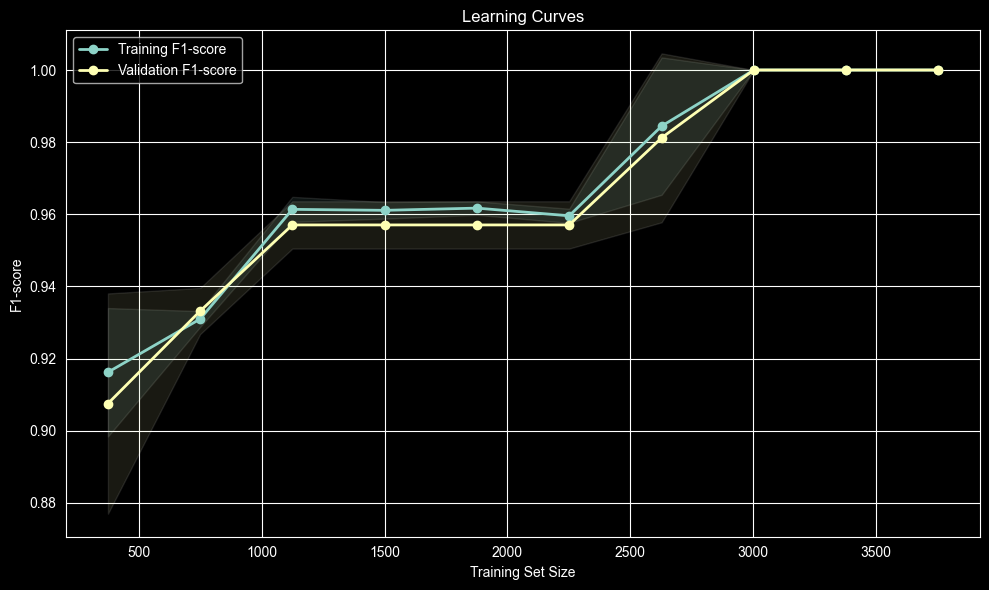

✓ Learning curves generated




In [25]:
# ============================================================================
# TEST 7: LEARNING CURVES
# ============================================================================
print("="*80)
print("TEST 7: LEARNING CURVES")
print("="*80)

train_sizes, train_scores, val_scores = learning_curve(
    final_pipeline, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training F1-score', linewidth=2)
plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation F1-score', linewidth=2)
plt.fill_between(train_sizes,
                  train_scores.mean(axis=1) - train_scores.std(axis=1),
                  train_scores.mean(axis=1) + train_scores.std(axis=1),
                  alpha=0.1)
plt.fill_between(train_sizes,
                  val_scores.mean(axis=1) - val_scores.std(axis=1),
                  val_scores.mean(axis=1) + val_scores.std(axis=1),
                  alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('F1-score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

print("✓ Learning curves generated")
print("\n" + "="*80 + "\n")

<Figure size 800x600 with 0 Axes>

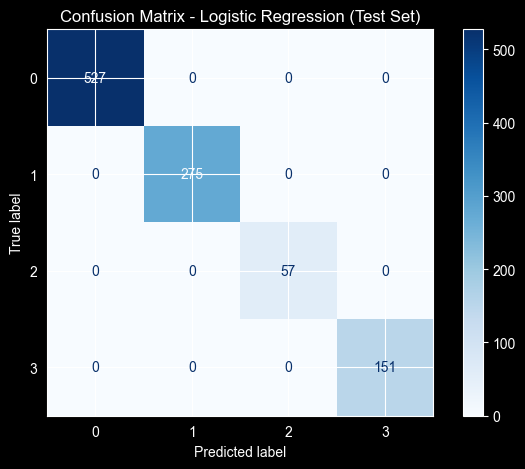

In [26]:
# ============================================================================
# CONFUSION MATRIX
# ============================================================================
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    final_pipeline,
    X_test,
    y_test,
    cmap="Blues",
    values_format="d"
)
plt.title(f"Confusion Matrix - {best_model_name} (Test Set)")
plt.tight_layout()
plt.show()

In [27]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\n🏆 Best Model: {best_model_name}")
print(f"\n📊 Performance Summary:")
print(f"   Training F1:    {train_f1:.6f}")
print(f"   Validation F1:  {val_f1:.6f}")
print(f"   Test F1:        {test_f1:.6f}")
print(f"\n📈 Overfitting Check:")
print(f"   Train-Test Gap: {abs(train_f1 - test_f1):.6f}", end="")
if abs(train_f1 - test_f1) < 0.05:
    print(" ✓ Good generalization")
else:
    print(" ⚠️ Possible overfitting")

print("\n" + "="*80)

FINAL SUMMARY

🏆 Best Model: Logistic Regression

📊 Performance Summary:
   Training F1:    1.000000
   Validation F1:  1.000000
   Test F1:        1.000000

📈 Overfitting Check:
   Train-Test Gap: 0.000000 ✓ Good generalization



In [28]:
# Vérifier la relation entre cluster et salaire
print("="*80)
print("VERIFICATION: Relation Cluster vs Salaire")
print("="*80)

# Grouper par cluster et voir les statistiques de salaire
cluster_salary = df.groupby('cluster')['salaire_annuel'].agg(['mean', 'min', 'max', 'std'])
print("\nStatistiques de salaire par cluster:")
print(cluster_salary)

# Vérifier si categorie_salaire est liée au cluster
crosstab = pd.crosstab(df['cluster'], df['categorie_salaire'])
print("\nTable croisée: Cluster vs Categorie Salaire")
print(crosstab)

# Correlation entre cluster et categorie_salaire
if 'categorie_salaire' in df.columns:
    corr = df['cluster'].corr(df['categorie_salaire'])
    print(f"\nCorrelation cluster vs categorie_salaire: {corr:.4f}")
    if abs(corr) > 0.9:
        print("⚠️ ALERTE: Très haute corrélation - POSSIBLE LEAKAGE!")

VERIFICATION: Relation Cluster vs Salaire

Statistiques de salaire par cluster:
                 mean      min      max          std
cluster                                             
0        39218.656980  28800.0  62070.0  8981.498398
1        25405.209924  21621.0  28000.0  1948.565376
2          934.000000    934.0    934.0     0.000000
3         1109.184080    934.0   1829.0   351.691715

Table croisée: Cluster vs Categorie Salaire
categorie_salaire     0     1
cluster                      
0                     0  3510
1                  1834     0
2                   383     0
3                  1005     0

Correlation cluster vs categorie_salaire: -0.8125
